## $\kappa$-velo scaling on simulation

In this notebook we will apply our $\kappa$-velo method to a simulated RNA-velocity dataset. 

We are interested in the recovery, and scaling of the parameters $\alpha$, $\beta$ and $\gamma$, which is one of the steps in the $\kappa$-velo workflow. You can use this notebook to reproduce figures 2B-E and S2.

In [1]:
### load libraries

# general libraries
import pandas as pd

# single cell libraries
import scvelo as scv

# plotting libraries
import matplotlib.pyplot as plt

# dimension reduction libraries
from sklearn.decomposition import PCA #for generating a PCA embedding
import sklearn as sk
from scipy.stats import pearsonr

import numpy as np
# import our own functions
%load_ext autoreload
%autoreload 2
from velocity.tools.fit import *

### Generate simulation data

We first generate a simulation data that we will be using to test our $\kappa$-velo method. The simulation is create using the build in function from scVelo: `scvelo.datasets.simulation`. Our simulation contains 200 genes and 5000 cells. The parameters $\alpha$, $\beta$ and $\gamma$ are sampled from a multivariate log-normal distribution and scaled by a scaling factor $\kappa$ between 1 and 10.

In [2]:
### set seed
np.random.seed(0)

In [3]:
### set variables for simulation
n_vars, n_obs, t_max, noise_level = 100, 5000, 30, 1
switches = np.random.uniform(.6, .7, size=n_vars)

In [4]:


### set parameters
mu = np.array([np.log(5), np.log(.3), np.log(.15)])
R = np.array([[1, .2, .2],
              [.2, 1, .2],
              [.2, .2, 1]])
C = np.array([.2, .2, .2])[:, None]
cov = C.dot(C.T) * R


alpha, beta, gamma = np.exp(np.random.multivariate_normal(mu, cov, size=n_vars).T ) 

In [5]:
### set different scaling factors (kappa)
kappa = np.arange(.1, 15, (15-.1)/n_vars)

In [6]:
### generate dataset; fixed alpha, beta & gamma, only change kappa 
adata = scv.datasets.simulation(n_obs=n_obs, 
                                t_max=t_max, 
                                n_vars=n_vars, 
                                noise_level=noise_level, 
                                alpha=alpha*kappa, 
                                beta=beta*kappa, 
                                gamma=gamma*kappa, 
                                switches=switches/kappa)

### Recover dynamics and scaling factors ($\kappa$)

Here, we will calculate the velocities per cell for each gene. 

We compare the parameters recovered by scVelo using the function `scvelo.tl.recover_dynamics`, to our parameters recvored using the ` recover_reaction_rate_pars` function.

In [7]:
### recover scvelo dynamics
scv.tl.recover_dynamics(adata, adata.var_names, use_raw=True, fit_connected_states=False, t_max=20)

recovering dynamics (using 1/8 cores)


  0%|          | 0/100 [00:00<?, ?gene/s]

    finished (0:00:24) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [8]:
### recover kappa-velo dynamics
scaled_data = recover_reaction_rate_pars(adata, 
                                         use_raw=True, # whether to use raw or inputed counts
                                         key="fit", # key under which the parameters are saved
                                         parallel=True, n_cores=4, # parallelisation for speed-up
                                         inplace=False # return new adata object instead of editing the existing one
                                        )

Compare our fitted kappa's to the true kappa's. This figure is equivalent to Figure 2C in our main paper.

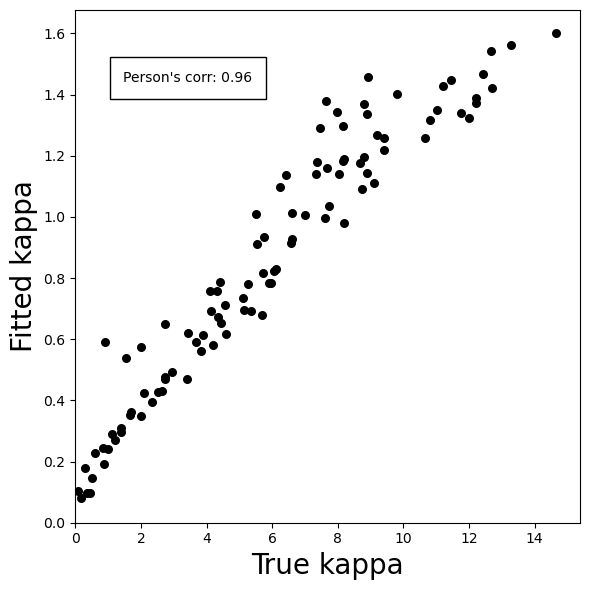

In [9]:
### plot fitted kappas vs true kappas
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
x, y = kappa*beta*2.5, scaled_data.var["fit_beta"]*100
plt.scatter(x, y, s=30, c="black")
plt.xlabel("True kappa", size=20), plt.ylabel("Fitted kappa", size=20)
plt.text(np.max(x)/10, np.max(y)-np.max(y)/10, "Person's corr: "+str(np.round(pearsonr(x, y)[0],2)), #style='italic',
        bbox={'facecolor': 'white', 'pad': 10})
plt.xlim(0), plt.ylim(0)
plt.tight_layout()

plt.show()

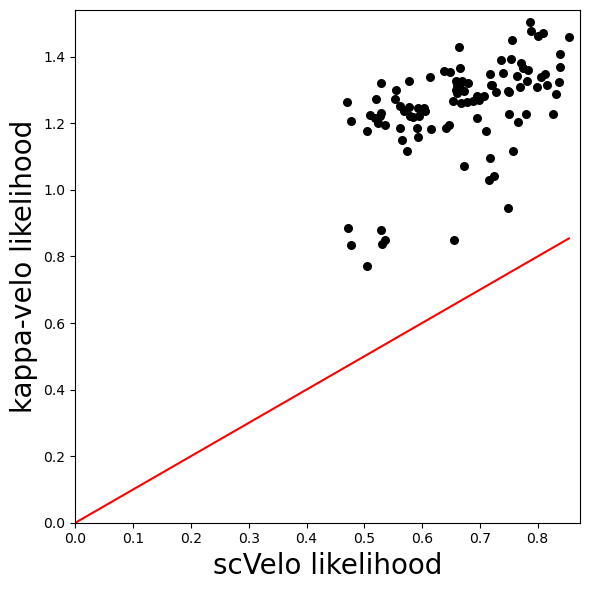

In [10]:
### plot scVelo likelihood vs our likelihood
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
x, y = adata.var["fit_likelihood"], scaled_data.var["fit_likelihood"]
plt.scatter(x, y, s=30, c="black")
plt.xlabel("scVelo likelihood", size=20), plt.ylabel("kappa-velo likelihood", size=20)
plt.xlim(0), plt.ylim(0)
plt.plot((0, np.max(x)), (0, np.max(x)), color="red")
plt.tight_layout()

plt.show()

### Calculate velocities

Compare the velocities calculated in three different ways. 

1. true velocities (`v_true`): velocities calculated using the ground truth parameters
2. scVelo velocities (`v_scvelo`): velocities calculated using the parameters recovered by scVelo
3. scaled velocities (`v_scaled`): velocities calculated using the $\kappa$-scaled parameters

Note: the velocities are L2 normalised to make them comparable.

In [16]:
### calculate ground truth velocities
from velocity.tools.fit import *
true_data = adata.copy()
get_velocity(true_data, key="true", normalise="std")
v_true = true_data.layers["velocity"]/10

In [17]:
### calculate scvelo velocities 
scv.pp.neighbors(adata)
scv.tl.velocity(adata, use_raw=True)
v_scvelo = (adata.layers["velocity"]/np.std(adata.layers["velocity"]))/10

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [18]:
### scaled velocities
get_velocity(scaled_data, use_raw=True, normalise="std")
v_scaled = scaled_data.layers["velocity"]/10

Compare the velocities estimated by scVelo and $\kappa$-velo to the true velocities. Each dot represents the velocity of one gene in one cell. 

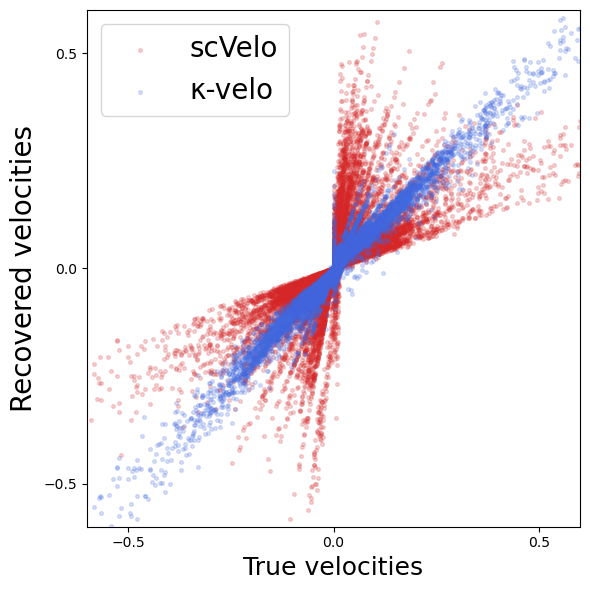

In [19]:
### plot figuring comparing scVelo and kappa-velo to ground truth
fig, ax = plt.subplots(1, 1, figsize=(6, 6), frameon=False)

kwargs = {"alpha":.2, "s":7}
idx = np.arange(0, n_vars, 1)
cells = np.arange(0, n_obs, 25)
xlim = (np.min(v_true), np.max(v_true))

# for all cell over all genes
ax.scatter(v_true[:,idx][cells], v_scvelo[:,idx][cells], 
           label="scVelo", color="tab:red", **kwargs)
ax.scatter(v_true[:,idx][cells], v_scaled[:,idx][cells], 
           label="κ-velo", color="royalblue", **kwargs)
ax.set_xlabel("True velocities", size=18), ax.set_ylabel("Recovered velocities", size=20)

l = .6
ax.set_xlim((-l,l)), ax.set_ylim((-l, l))

ax.legend(fontsize=20)
ax.set_xticks([-.5, 0, .5]), ax.set_yticks([-.5, 0, .5])
plt.tight_layout()

# save figure
save_path = "../figures/simulation/FigS9A_velocities-scvelo-vs-scaled.pdf"
plt.savefig(save_path, dpi=200, transparent=True)

plt.show()

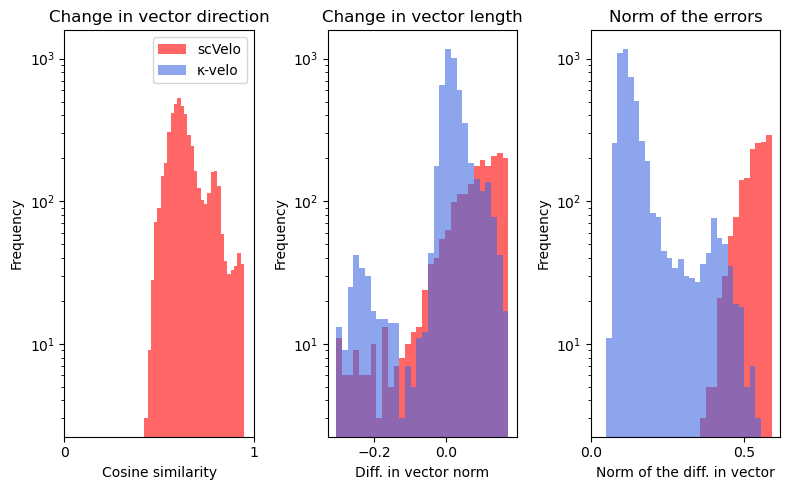

In [20]:
from velocity.project.nystroem_utils import vector_distance
### calculate change in direction
a0, a1 = vector_distance(v_true, v_scvelo, metric="cosine"), vector_distance(v_true, v_scaled, metric="cosine")
### calculate change in angle
d0, d1 = vector_distance(v_true, v_scvelo, metric="norm_diff"), vector_distance(v_true, v_scaled, metric="norm_diff")
n0, n1 = vector_distance(v_true, v_scvelo, metric="diff_norm"), vector_distance(v_true, v_scaled, metric="diff_norm")

fig, axs = plt.subplots(1, 3, figsize=(8,5), frameon=False, gridspec_kw={'width_ratios': [ 1, 1, 1]})


kwargs = {"alpha":0.5, "density":False, "bins":30}
A= np.array((a0.tolist(), a1.tolist())).flatten()
_, bins, _ = axs[0].hist(a0, **kwargs, color="white")
axs[0].hist(a0, bins=bins, alpha=.6, label="scVelo", color="r")
axs[0].hist(a1, bins=bins, alpha = .6, color="royalblue", label="κ-velo")
axs[0].set_title("Change in vector direction")
axs[0].set_yscale('log') 
axs[0].set_ylabel("Frequency")
axs[0].set_xlabel("Cosine similarity")
axs[0].set_xticks([0,1])
axs[0].legend()
#kwargs = {"alpha":0.5, "density":False, "bins":21}
_, bins, _ = axs[1].hist(d1, **kwargs, color="white")
axs[1].hist(d0, bins=bins, alpha = .6, label="scVelo", color="r")
axs[1].hist(d1, bins=bins, alpha = .6, color="royalblue", label="κ-velo")
axs[1].set_title("Change in vector length")
axs[1].set_yscale('log') 
axs[0].sharey(axs[1])
axs[1].set_ylabel("Frequency")
axs[1].set_xlabel("Diff. in vector norm")
#axs[1].set_xticks([-1,0,1])

kwargs = {"alpha":0.5, "density":False, "bins":30}
_, bins, _ = axs[2].hist(n1, **kwargs, color="white")
axs[2].hist(n0, bins=bins, alpha = .6, label="scVelo", color="r")
axs[2].hist(n1, bins=bins, alpha = .6, color="royalblue", label="κ-velo")
axs[2].set_title("Norm of the errors")
axs[2].set_yscale('log') 
axs[2].sharey(axs[1])
axs[2].set_ylabel("Frequency")
axs[2].set_xlabel("Norm of the diff. in vector")
axs[2].set_xticks([0,.5])

axs[0].legend(fontsize=10)
plt.tight_layout()

# save figure
save_path = "../figures/simulation/FigS9B_length_and_direction_compared_high-D.pdf"
plt.savefig(save_path, dpi=200, transparent=True)

plt.show()

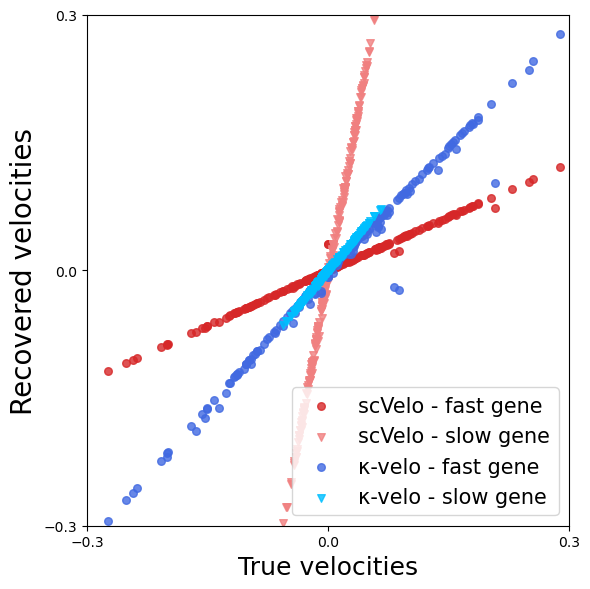

In [21]:
### plot figuring comparing scVelo and kappa-velo to ground truth
fig, ax = plt.subplots(1, 1, figsize=(6, 6), frameon=False)

kwargs = {"alpha":.8, "s":30}
idx = [10,80]
cells = np.arange(0, n_obs, 20)
xlim = (np.min(v_true), np.max(v_true))

# for all cell over all genes
ax.scatter(v_true[:,idx[1]][cells], v_scvelo[:,idx[1]][cells], 
           label="scVelo - fast gene", color="tab:red",  **kwargs)
ax.scatter(v_true[:,idx[0]][cells], v_scvelo[:,idx[0]][cells], 
           label="scVelo - slow gene", color="lightcoral",marker="v", **kwargs)
ax.scatter(v_true[:,idx[1]][cells], v_scaled[:,idx[1]][cells], 
           label="κ-velo - fast gene", color="royalblue", **kwargs)
ax.scatter(v_true[:,idx[0]][cells], v_scaled[:,idx[0]][cells], 
           label="κ-velo - slow gene", color="deepskyblue",marker="v", **kwargs)


ax.set_xlabel("True velocities", size=18), ax.set_ylabel("Recovered velocities", size=20)

l = .3
ax.set_xlim((-l,l)), ax.set_ylim((-l, l))

ax.legend(fontsize=15)
ax.set_xticks([-l, 0, l]), ax.set_yticks([-l, 0, l])
plt.tight_layout()

plt.show()

### Projection onto PCA space

To compare the velocities onto a low-dimensional embedding, we project the velocities, as calculated by scVelo and $\kappa$-velo onto a PCA embedding and compare them with the true velocities. We compare the velocities both in terms of change in vector direction and change in vector length. 
To compare the vector direction, we use our function `vector_distance`, which uses cosine similarity to determine the difference in direction between two vectors. To compare the vector length, we use the same function `vector_distance`, but this time with metric "norm_diff", comparing the length of the vector using the difference in vector norm.

In [22]:
### generate PCA embedding using spliced counts
pca = PCA(n_components=2, copy=True)
pc = pca.fit(adata.layers["spliced"])
data = pc.transform(adata.layers["spliced"])

In [23]:
### calculate projection of velocities (true, scVelo and scaled) onto PCA
zero = pca.transform(np.zeros((1,n_vars)))

v_t = pca.transform(v_true)-zero#, norm="l2")
v_0 = pca.transform(v_scvelo)-zero#, norm="l2")
v_1 = pca.transform(v_scaled)-zero#, norm="l2")

In [24]:
### calculate change in direction
a0, a1 = vector_distance(v_t, v_0, metric="cosine"), vector_distance(v_t, v_1, metric="cosine")
### calculate change in angle
d0, d1 = vector_distance(v_t, v_0, metric="norm_diff"), vector_distance(v_t, v_1, metric="norm_diff")

d0_, d1_ = vector_distance(v_t, v_0, metric="diff_norm"), vector_distance(v_t, v_1, metric="diff_norm")

In [25]:
sub = np.arange(0, len(v_t), 4)

Plot the simulation in a PCA embedding. The grey velocities represent the true velocities. The red and blue velocities represent the scVelo-calculate and kappa-scaled velocities respectively.

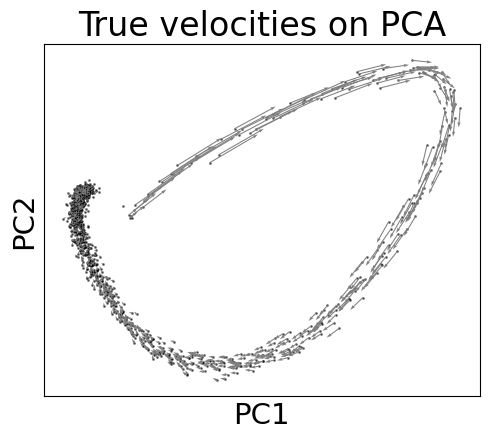

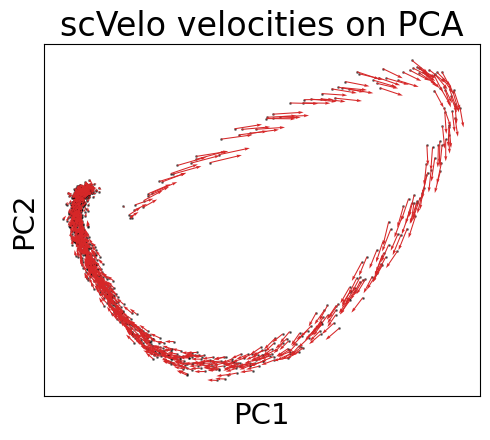

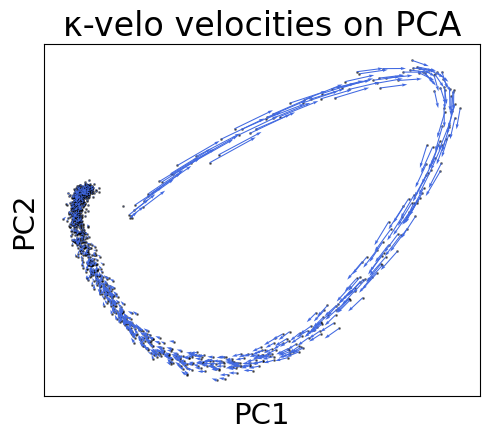

In [26]:
quiver_kwargs = {"scale": .1, "angles": "xy", "scale_units": "xy",
                 #"edgecolors": "k", "linewidth": 0.1, "headwidth": 5, "headaxislength": 4, "alpha":.8
                }

path = "../figures/simulation/"

titles = ["True velocities on PCA", "scVelo velocities on PCA",
         "κ-velo velocities on PCA"]
color = ["grey", "tab:red", "royalblue"]
vec = [v_t, v_0, v_1]
save_name = ["FigS10A_real_velo_PCA", "FigS10C_scVelo_velo_PCA", "FigS10B_kvelo_velo_PCA"]
for i in range(3):
    fig, axs = plt.subplots(1,1, figsize=(5, 4.5), frameon=False)
    axs.scatter(data[sub,0], data[sub,1], s=1, c="black", alpha=.5)
    axs.quiver(data[sub,0], data[sub,1], vec[i][sub,0], vec[i][sub,1], color=color[i], **quiver_kwargs)
    axs.set_title(titles[i], fontsize=24)
    axs.set_xlabel("PC1", fontsize=21)
    axs.set_ylabel("PC2", fontsize=21)
    axs.set_yticks([])
    axs.set_xticks([])
    plt.tight_layout()
    plt.savefig(path+save_name[i]+".png", dpi=200, transparent=True)

plt.show()

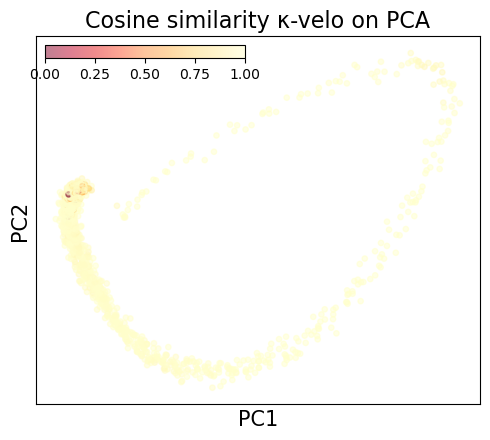

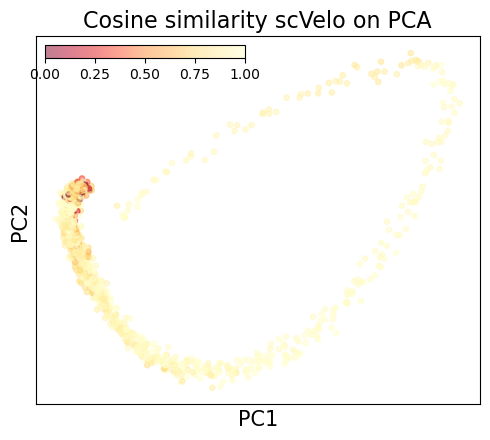

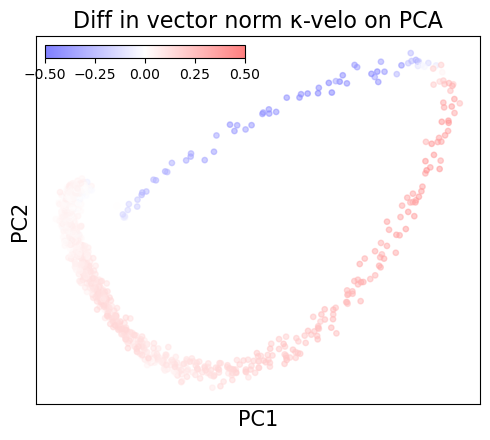

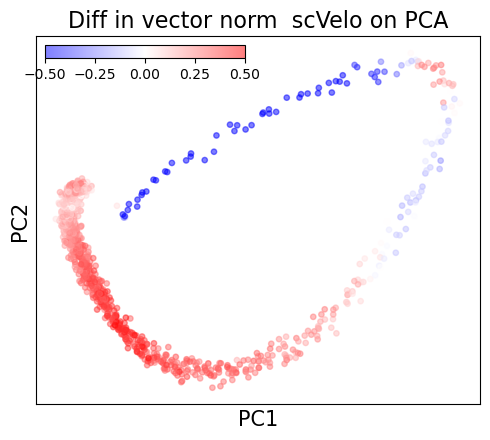

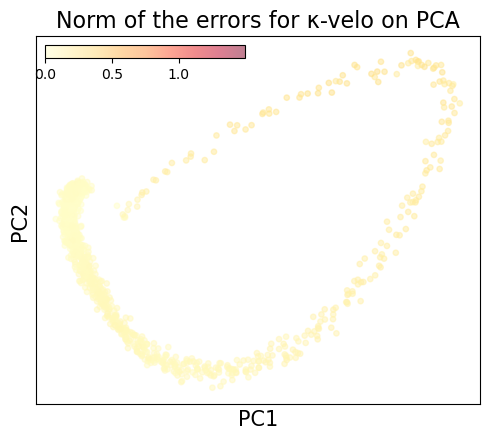

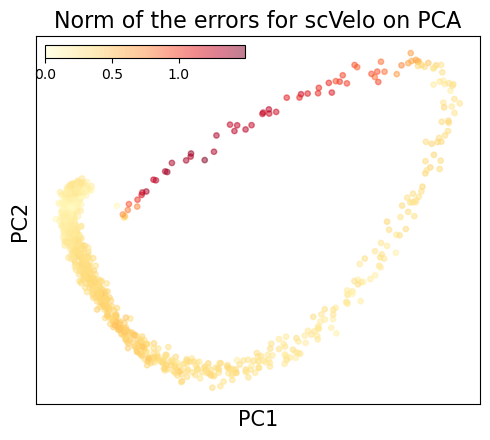

In [27]:
titles = ["Cosine similarity κ-velo on PCA", "Cosine similarity scVelo on PCA",
         "Diff in vector norm κ-velo on PCA", "Diff in vector norm  scVelo on PCA",
         "Norm of the errors for κ-velo on PCA", "Norm of the errors for scVelo on PCA"]
color = [a1, a0, d1, d0, d1_, d0_]
cmaps = ["YlOrRd_r", "YlOrRd_r", 
         "bwr", "bwr",
        "YlOrRd", "YlOrRd"]
vmin_vmax = [(0, 1), (0, 1), 
             (-.5, .5), (-.5, .5), 
             (0, np.max(d0_)), (0, np.max(d0_))]
save_name = ["Fig_cosine_kvelo_PCA", "Fig_cosine_scVelo_PCA", 
             "Fig_norm_kvelo_PCA", "Fig_norm_scVelo_PCA",
             "FigS10D_errors_kvelo_PCA", "FigS10E_errors_scVelo_PCA"]
for i in range(6):
    fig, axs = plt.subplots(1,1, figsize=(5, 4.5), frameon=False)
    vmin, vmax=vmin_vmax[i]
    im = axs.scatter(data[sub,0], data[sub,1], s=15, c=color[i][sub], alpha=.5, vmin=vmin, vmax=vmax, cmap=cmaps[i])
    cax = fig.add_axes([0.1, 0.86, 0.4, 0.03])
    fig.colorbar(im, cax=cax, orientation='horizontal')
    axs.set_title(titles[i], fontsize=16)
    axs.set_xlabel("PC1", fontsize=15)
    axs.set_ylabel("PC2", fontsize=15)
    axs.set_yticks([])
    axs.set_xticks([])
    plt.tight_layout()
    plt.savefig(path+save_name[i]+".pdf", dpi=200, transparent=True)

plt.show()

Here, we compare the vectors in the PCA embedding in terms of size and angle.

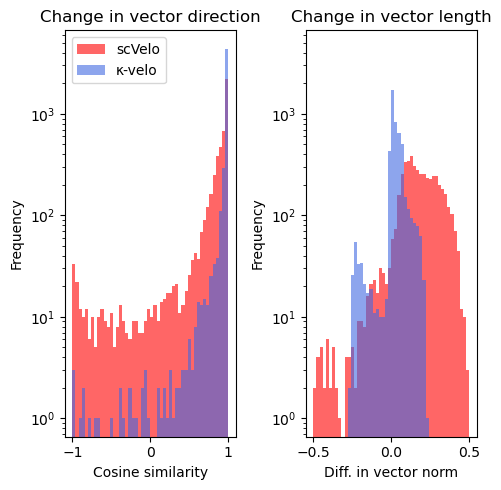

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(5,5), frameon=False, gridspec_kw={'width_ratios': [ 1, 1]})


kwargs = {"alpha":0.5, "density":False, "bins":50}
A= np.array((a0.tolist(), a1.tolist())).flatten()
_, bins, _ = axs[0].hist(a0, **kwargs, color="white")
axs[0].hist(a0, bins=bins, alpha=.6, label="scVelo", color="r")
axs[0].hist(a1, bins=bins, alpha = .6, color="royalblue", label="κ-velo")
axs[0].set_title("Change in vector direction")
#axs[0].set_xticks([0.5, 1])
axs[0].set_yscale('log') 
axs[0].set_ylabel("Frequency")
axs[0].set_xlabel("Cosine similarity")
axs[0].legend()

D= np.array((d0.tolist(), d1.tolist())).flatten()
_, bins, _ = axs[1].hist(d0, **kwargs, color="white", range=(-.5, .5))
axs[1].hist(d0, bins=bins, alpha = .6, label="scVelo", color="r")
axs[1].hist(d1, bins=bins, alpha = .6, color="royalblue", label="κ-velo")
axs[1].set_title("Change in vector length")
axs[1].set_yscale('log') 
axs[1].sharey(axs[0])
axs[1].set_ylabel("Frequency")
axs[1].set_xlabel("Diff. in vector norm")
#axs[1].set_xticks([-1,0,1])

axs[0].legend(fontsize=10)
plt.tight_layout()

# save figure
save_path = "../figures/simulation/Fig3E_length_and_direction_compared.pdf"
plt.savefig(save_path, dpi=200, transparent=True)

plt.show()

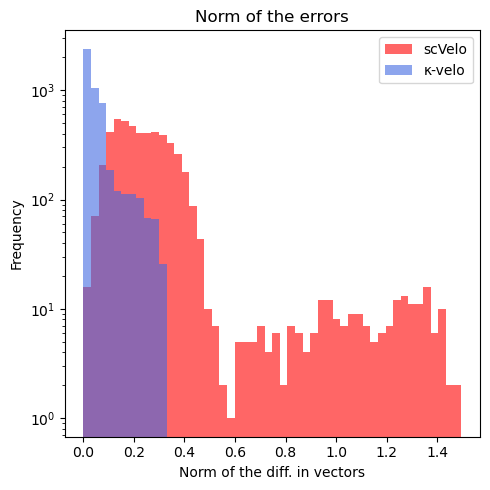

In [29]:
fig, axs = plt.subplots(1, 1, figsize=(5,5), frameon=False)
axs=[axs]

kwargs = {"alpha":0.5, "density":False, "bins":50}

D= np.array((d0_.tolist(), d1_.tolist())).flatten()
_, bins, _ = axs[0].hist(d0_, **kwargs, color="white")#, range=(0, .5))
axs[0].hist(d0_, bins=bins, alpha = .6, label="scVelo", color="r")
axs[0].hist(d1_, bins=bins, alpha = .6, color="royalblue", label="κ-velo")
axs[0].set_title("Norm of the errors")
axs[0].set_yscale('log') 
axs[0].set_ylabel("Frequency")
axs[0].set_xlabel("Norm of the diff. in vectors")
#axs[1].set_xticks([0,1])

axs[0].legend(fontsize=10)
plt.tight_layout()

# save figure
save_path = "../figures/simulation/FigS11A_norm_of_the_errors.pdf"
plt.savefig(save_path, dpi=200, transparent=True)

plt.show()

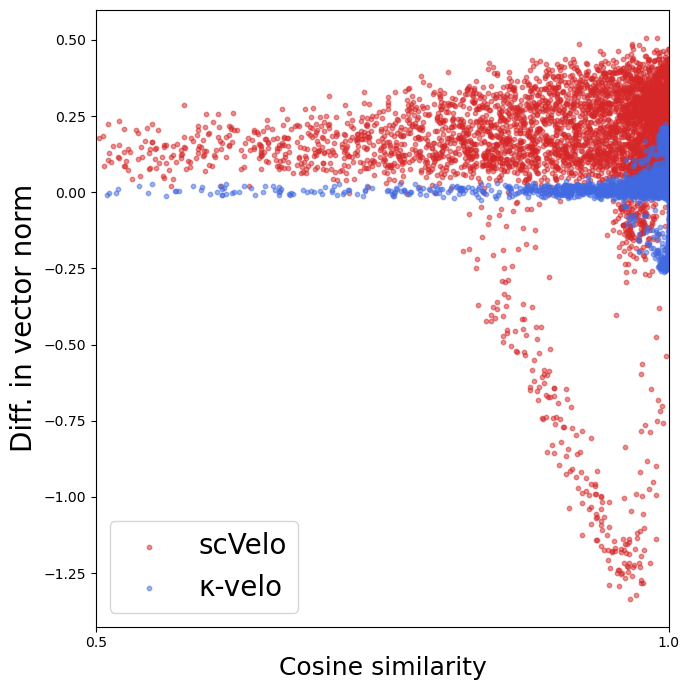

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(7,7), frameon=False)
kwargs = {"alpha":.5, "s":10}
plt.scatter(a0, d0, label="scVelo", color="tab:red", **kwargs)
plt.scatter(a1, d1, color="royalblue", label="κ-velo", **kwargs)
plt.xlim(0.5, 1)
ax.set_xlabel("Cosine similarity", size=18), ax.set_ylabel("Diff. in vector norm", size=20)
ax.legend(fontsize=20)
ax.set_xticks([ 0.5, 1])
plt.tight_layout()

# save figure
save_path = "../figures/simulation/FigS11B_error_by_cosine.pdf"
plt.savefig(save_path, dpi=200, transparent=True)


plt.show()

Plot all three figures (Figure 2C-E) in the same figure. 

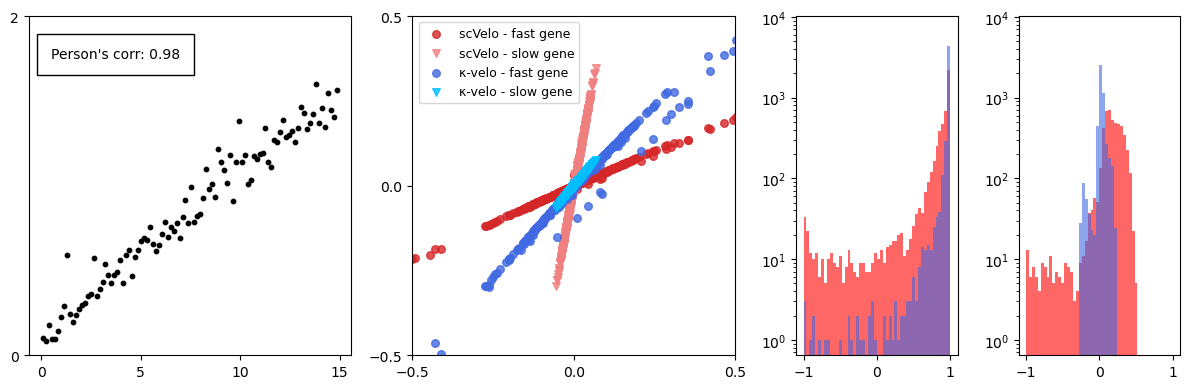

In [31]:
### plot all three figures together
fig, axs = plt.subplots(1, 4, figsize=(12,4), frameon=False, gridspec_kw={'width_ratios': [2, 2, 1, 1]})

# plot recovered kappas
x, y = kappa, scaled_data.var["fit_beta"]*100
axs[0].scatter(x, y, s=10, c="black")
axs[0].set_xticks([0, 5, 10, 15])
axs[0].set_yticks([0, 2])
axs[0].text(np.max(x)/30, np.max(y)+0.15, "Person's corr: "+str(np.round(pearsonr(x, y)[0],2)), bbox={'facecolor': 'white', 'pad': 10})

# plot velocities comparison 
kwargs = {"alpha":.8, "s":30}
idx = [10,80]
cells = np.arange(0, n_obs, 10)
xlim = (np.min(v_true), np.max(v_true))

# for all cell over all genes
axs[1].scatter(v_true[:,idx[1]][cells], v_scvelo[:,idx[1]][cells], 
           label="scVelo - fast gene", color="tab:red",  **kwargs)
axs[1].scatter(v_true[:,idx[0]][cells], v_scvelo[:,idx[0]][cells], 
           label="scVelo - slow gene", color="lightcoral",marker="v", **kwargs)
axs[1].scatter(v_true[:,idx[1]][cells], v_scaled[:,idx[1]][cells], 
           label="κ-velo - fast gene", color="royalblue", **kwargs)
axs[1].scatter(v_true[:,idx[0]][cells], v_scaled[:,idx[0]][cells], 
           label="κ-velo - slow gene", color="deepskyblue",marker="v", **kwargs)
l = .3
axs[1].set_xlim((-l,l)), axs[1].set_ylim((-l, l))
axs[1].legend(fontsize=9)
axs[1].set_xticks([-.5, 0, .5]), axs[1].set_yticks([-.5, 0, .5])
# plot direction comparison
axs[2].set_yscale('log') 
kwargs = {"alpha":0.5, "density":False, "bins":50}
_, bins, _ = axs[2].hist(A, **kwargs, color="white")
axs[2].hist(a0, bins=bins, alpha=.6, label="scVelo", color="r")
axs[2].hist(a1, bins=bins, alpha = .6, color="royalblue", label=["k-velo"])
axs[2].set_xticks([-1, 0, 1])
axs[2].set_yscale('log') 
# plot size comparison
_, bins, _ = axs[3].hist(D, **kwargs, color="white", range=(-1, 1))
axs[3].hist(d0, bins=bins, alpha = .6, label="scVelo", color="r")
axs[3].hist(d1, bins=bins, alpha = .6, color="royalblue", label=["K-SV"])
axs[3].set_yscale('log') 
axs[3].sharey(axs[2])
axs[3].set_xticks([-1, 0, 1])
plt.tight_layout()

# save figure
save_path = "../figures/simulation/Fig3C-E_kappa_on_simulation.png"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

# Supplementary figures

### (1) Kappa from real time 

In [32]:
from velocity.tools.kappa_utils import *

time = np.array(adata.obs.true_t.tolist())

kappa_true_t = []
for gene in adata.var_names:

    reg, key, n = "up", "fit", 5000
    alpha, beta, gamma, u, s, up_reg, down_reg = get_pars(adata, gene, key)

    # in the case where we have a proxy of time we can also use it to assign cells to up 
    # and down-reg and ajust potential errors

    up_reg = (time < adata[:,gene].var["true_t_"][0])

    r_ = up_reg if reg == "up" else down_reg

    ordr = np.argsort(u[r_]) if reg == "up" else np.argsort(-u[r_])
    reg_idx = np.where(r_)[0][ordr]
    i = sample(n, u, reg, reg_idx)  # sampling of random pairs
    delta_t = np.abs(time[i[1]] - time[i[0]])  # number of cells between i[0] and i[1]
    (u0, u1) = u[i[0]], u[i[1]]  # u values for i[0] and i[1]

    f = f_u(alpha if reg == "up" else 0, beta, u1, u0)
    kappa_true_t.append( np.sum(f)/np.sum(delta_t))
    #kappa_true_t.append(get_slope(delta_t, f))

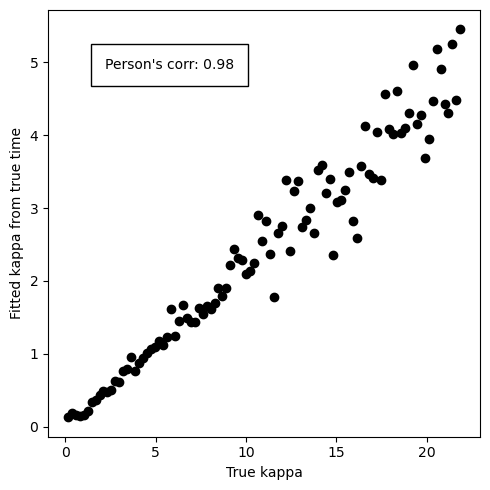

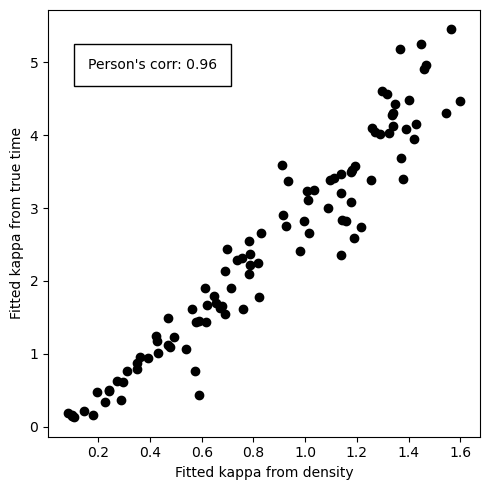

In [33]:

fig, axs = plt.subplots(1, 1, figsize=(5,5), frameon=False)

x, y = kappa*beta, kappa_true_t*adata.var["fit_beta"]
axs.scatter(x, y, color="black")
axs.set_xlabel("True kappa")
axs.set_ylabel("Fitted kappa from true time")
axs.text(np.max(x)/10, np.max(y)-np.max(y)/10, "Person's corr: "+str(np.round(pearsonr(x, y)[0],2)), #style='italic',
        bbox={'facecolor': 'white', 'pad': 10})
plt.tight_layout()
# save figure
save_path = "../figures/FigS8A_kappa_from_true_t_A.pdf"
plt.savefig(save_path, dpi=100, transparent=True)


fig, axs = plt.subplots(1, 1, figsize=(5,5), frameon=False)
x, y = scaled_data.var["fit_beta"]*100, kappa_true_t*adata.var["fit_beta"]
axs.scatter(x, y, color="black")
axs.set_xlabel("Fitted kappa from density")
axs.set_ylabel("Fitted kappa from true time")
axs.text(np.max(x)/10, np.max(y)-np.max(y)/10, "Person's corr: "+str(np.round(pearsonr(x, y)[0],2)), #style='italic',
        bbox={'facecolor': 'white', 'pad': 10})
plt.tight_layout()
# save figure
save_path = "../figures/simulation/FigS8B_kappa_from_true_t_B.pdf"
plt.savefig(save_path, dpi=100, transparent=True)

plt.show()

### (2) Kappa from s

In [34]:
### get kappa and scale anndata object
beta_s = np.ones(scaled_data.shape[1])
beta_u = scaled_data.var.fit_beta

alpha, gamma, Uk = scaled_data.var.fit_alpha, scaled_data.var.fit_gamma, scaled_data.var.fit_U_switch
scaling = scaled_data.var.fit_scaling
Pi = scaled_data.layers["fit_Pi"]
unspliced, spliced = adata.layers["unspliced"], adata.layers["spliced"]
for i in range(scaled_data.shape[1]):
    if np.isnan(beta_u[i]):
        beta_s[i] = np.nan
    else:
        k = (unspliced[:,i] * scaling[i]) > (gamma[i]/beta_u[i] * spliced[:,i])
        st = S(alpha[i]/beta_u[i], gamma[i]/beta_u[i], 0, 0, Pi[:,i])
        beta_s[i] = get_kappa(alpha=alpha[i]/beta_u[i], beta=1, gamma=gamma[i]/beta_u[i], 
                              ut=Pi[:,i], st=st, u_switch=Uk[i], k=k, mode="s")




Optimization terminated successfully.
         Current function value: 2.693786
         Iterations: 290
         Function evaluations: 509
Optimization terminated successfully.
         Current function value: 7.670824
         Iterations: 242
         Function evaluations: 422
Optimization terminated successfully.
         Current function value: 10.278477
         Iterations: 279
         Function evaluations: 490
Optimization terminated successfully.
         Current function value: 21.248489
         Iterations: 269
         Function evaluations: 474
Optimization terminated successfully.
         Current function value: 3.242781
         Iterations: 376
         Function evaluations: 659
Optimization terminated successfully.
         Current function value: 4.879256
         Iterations: 662
         Function evaluations: 1115
Optimization terminated successfully.
         Current function value: 10.982144
         Iterations: 690
         Function evaluations: 1146
Optimization te

Optimization terminated successfully.
         Current function value: 42.273675
         Iterations: 362
         Function evaluations: 606
Optimization terminated successfully.
         Current function value: 44.051968
         Iterations: 467
         Function evaluations: 800
Optimization terminated successfully.
         Current function value: 40.663408
         Iterations: 180
         Function evaluations: 318
Optimization terminated successfully.
         Current function value: 44.818366
         Iterations: 326
         Function evaluations: 565
Optimization terminated successfully.
         Current function value: 45.199565
         Iterations: 233
         Function evaluations: 411
Optimization terminated successfully.
         Current function value: 44.505290
         Iterations: 281
         Function evaluations: 478
Optimization terminated successfully.
         Current function value: 42.732032
         Iterations: 303
         Function evaluations: 517
Optimization 

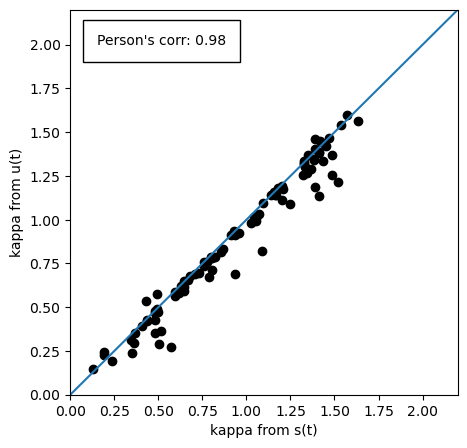

In [35]:
fig, axs = plt.subplots(1, 1, figsize=(5,5), frameon=False)
x, y = beta_s.astype(float)*100, beta_u.astype(float)*100
sub = (~np.isnan(y))&(~np.isnan(x))&(x!=-np.infty)
x, y = x[sub], y[sub]
plt.scatter(x, y, c="black")
axs.text(.15, 2, 
         "Person's corr: "+str(np.round(pearsonr(x, y)[0],2)),
        bbox={'facecolor': 'white', 'pad': 10})
axs.set_xlim((0, 2.2))
axs.set_ylim((0, 2.2))
axs.plot([0, 2.2], [0, 2.2])
plt.xlabel("kappa from s(t)")
plt.ylabel("kappa from u(t)")
plt.savefig("../figures/simulation/FigS3A_kappa_from_S_sim.pdf", dpi=200, transparent=True)
plt.show()

### (3) parallelogram approach
To give you some insight on how $\kappa$-velo calculate scaling factor $\kappa$ for each gene, we zoom in on the application of the parallelogram approach on two genes a similar simulation. To get a better understanding of the approach, we highly recommend you to read Supplementary Note 1 in our manuscript. Below, you will find for both genes the u-s phase portrait and a scatter plot plotting $d(i,j)$ and $f(i,j)$, with a parellologram fitted around the points. The slope of the left border of the parellogram is used as an estimate for $\kappa$.

In [36]:
### define kwargs & functions 
ptkwargs = {"s":3, "color":"grey", "alpha":.8}
lkwargs = dict(bounds=[(0.1, None)], x0=np.array([.1]), options={"maxiter": 2000, 'disp': True}, tol=1e-8, method="COBYLA")

def line(a, *args):
    x, y = args[0], args[1]
    x, y = x[x > .1], y[x > .1]
    return np.sum(np.sqrt(((a*x)-y)**2))

In [37]:
### create new simulation 
np.random.seed(2)

n_vars, n_obs, t_max, noise_level = 2, 3000, 20, [0.8]

kappa = np.array([.5, 5])
alpha, beta, gamma, switches = 5*kappa, .3*kappa, .15*kappa, [.8, .8]
adata = scv.datasets.simulation(n_obs=n_obs, t_max=t_max, n_vars=n_vars, noise_level=noise_level, alpha=alpha, beta=beta, gamma=gamma, switches=switches)

scv.tl.recover_dynamics(adata, use_raw=True, max_iter=1000)

recovering dynamics (using 1/8 cores)
    finished (0:00:01) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)

outputs model fit of gene: 1


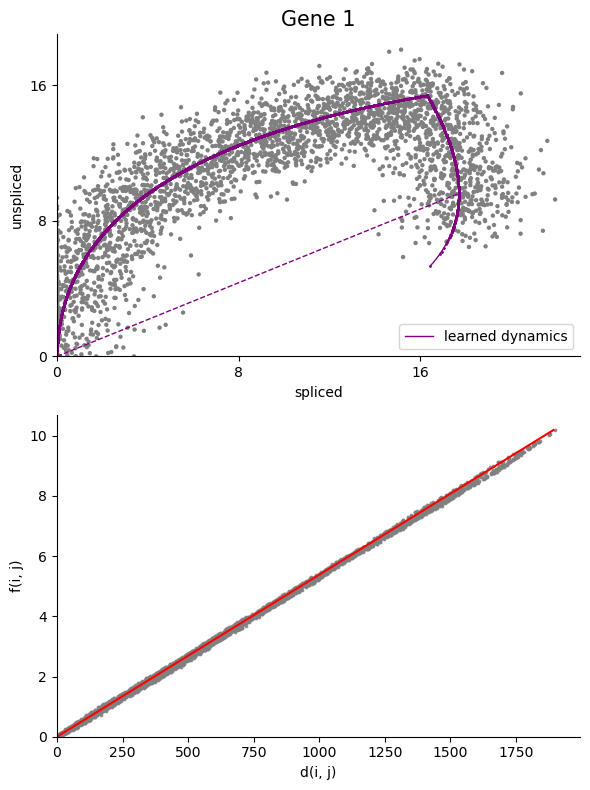

In [38]:
### plot parallelogram approach for gene 1
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

j = "0"
alpha, beta, gamma, ut, st, up_reg, down_reg = get_pars(adata, j)

# plot almond
scv.pl.scatter(adata,j, ax=ax[0], show=False, use_raw=True)
ax[0].set_title("Gene 1", size=15)

# get density kappa
alpha, beta, gamma, ut, st, up_reg, _ = get_pars(adata, j)
t_dist, f = get_f_and_delta_t(ut, st, alpha, beta, _, up_reg, "up")
a = op.minimize(line, args=(t_dist / np.max(t_dist), f / np.max(f)), **lkwargs).x

# plot density kappa
ax[1].scatter(t_dist, f,  **ptkwargs)
ax[1].set_xlabel("d(i, j)"), ax[1].set_ylabel("f(i, j)")
ax[1].plot(np.array([0, a]) * np.max(t_dist), np.array([0, 1]) * np.max(f), color="red")

# make plot less crowded
for ax_ in ax:
    ax_.set_xlim(0), ax_.set_ylim(0)
    ax_.spines['right'].set_visible(False)
    ax_.spines['top'].set_visible(False)

plt.tight_layout()

# save figure
save_path = "../figures/simulation/FigS2A_density-parallelogram.pdf"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

In [ ]:
### print recovered kappa for gene 1
print(((1 * np.max(f)) / (a * np.max(t_dist)))*beta *100)

In [ ]:
### plot parallelogram approach for gene 2
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

j = "1"
alpha, beta, gamma, ut, st, up_reg, down_reg = get_pars(adata, j)

# plot almond
scv.pl.scatter(adata,j, ax=ax[0], show=False, use_raw=True)
ax[0].set_title("Gene 2", size=15)

# plot density kappa
t_dist, f = get_f_and_delta_t(ut, st, alpha, beta, _, up_reg, "up")

kwargs = dict(bounds=[(0.1, None), (0.1, None), (0.1, None), (0.01, None)], x0=np.array([.1, 1, 1, .1]),
              options={"maxiter": 2000, 'disp': True}, tol=1e-8, method="COBYLA")
mn = op.minimize(cost_parallelogram, args=(t_dist / np.max(t_dist), f / np.max(f)), **kwargs)
a, b, c, d = mn.x

ax[1].scatter(t_dist, f, **ptkwargs)
ax[1].set_xlabel("d(i, j)"), ax[1].set_ylabel("f(i, j)")

# recovered kappa line
ax[1].plot(np.array([0, a]) * np.max(t_dist), np.array([0, b]) * np.max(f), color="red")

# rest of parallelogram
ax[1].plot(np.array([a, (a + c), c, 0]) * np.max(t_dist), np.array([b, (b + d), d, 0]) * np.max(f), color="orange")

for ax_ in ax:
    ax_.set_xlim(0), ax_.set_ylim(0)
    ax_.spines['right'].set_visible(False)
    ax_.spines['top'].set_visible(False)

plt.tight_layout()

# save figure
save_path = "../figures/FigS2B_density-parallelogram.pdf"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()